In [125]:
##センチメントアルゴリズムの実装
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import calendar
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

In [126]:
##ニュースデータの生成
#データの設定
k = 10   
year_count = 10
month = np.tile(np.arange(12), year_count) + 1
year = np.repeat(np.arange(year_count), 12) + 2010
n = len(year)   #経済指標発表数
m = np.repeat(0, n)  
for i in range(n):
    m[i] = calendar.monthrange(year[i], month[i])[1]
d = np.sum(m)   #日付数
month_id = np.repeat(np.arange(n), m)
day_id = np.array(list(itertools.chain(*[np.array(range(m[i]), dtype="int") for i in range(n)])))
days = day_id.shape[0]   #日付数
v1 = 50; v2 = 50   #ニュースパターン数
N1 = days*v1; N2 = days*v2
k_vec = np.repeat(1.0, k)

In [127]:
#idを設定
d_id1 = np.repeat(np.arange(days), v1)
d_id2 = np.repeat(np.arange(days), v2)
news_id1 = np.tile(np.arange(v1), days)
news_id2 = np.tile(np.arange(v2), days)

In [131]:
##応答変数を生成
#モデルパラメータの生成
beta_u1 = np.random.gamma(0.2, 1/1.0, days)
beta_u2 = np.random.gamma(0.2, 1/1.0, days)
beta_v1 = np.random.gamma(0.3, 1/1.0, v1)
beta_v2 = np.random.gamma(0.3, 1/1.0, v2)
theta_u = np.random.gamma(0.25, 1/0.75, days*k).reshape(days, k)
theta_v1 = np.random.gamma(0.2, 1/0.75, v1*k).reshape(v1, k)
theta_v2 = np.random.gamma(0.2, 1/0.75, v2*k).reshape(v2, k)
betat_u1 = beta_u1.copy(); betat_u2 = beta_u2.copy(); betat_v1 = beta_v1.copy(); betat_v2 = beta_v2.copy()
thetat_u = theta_u.copy(); thetat_v1 = theta_v1.copy(); thetat_v2 = theta_v2.copy()

#ポアソン分布からニュース頻度を生成
uv1 = np.dot(theta_u[d_id1, ] * theta_v1[news_id1, ], k_vec)
uv2 = np.dot(theta_u[d_id1, ] * theta_v2[news_id2, ], k_vec)
mu1 = beta_u1[d_id1] + beta_v1[news_id1] + uv1
mu2 = beta_u2[d_id2] + beta_v2[news_id2] + uv2
y1 = np.random.poisson(mu1, N1)
y2 = np.random.poisson(mu2, N2)

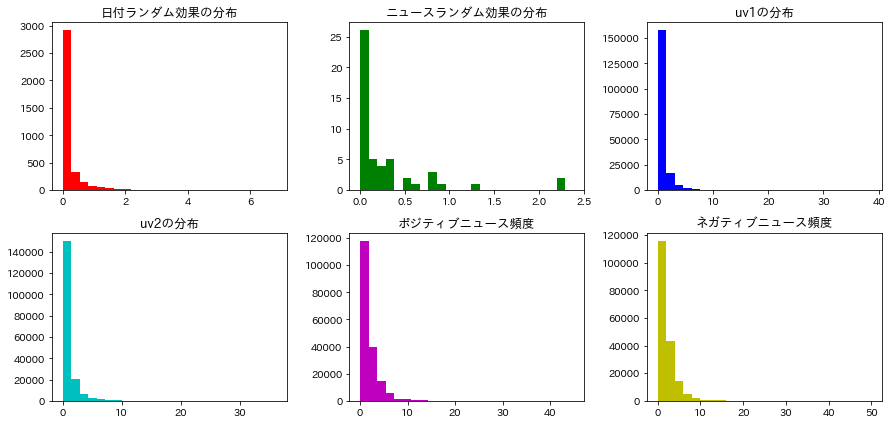

In [119]:
#生成したデータのヒストグラム
dt = [beta_u1, beta_v1, uv1, uv2, y1, y2]
fig_range = np.append(np.array([np.min(np.append(beta_u1, beta_u2)), np.min(np.append(beta_v1, beta_v2)), 
                                np.min(uv1), np.min(uv2), 0.0, 0.0]), 
                      np.array([np.max(np.append(beta_u1, beta_u2)), np.max(np.append(beta_v1, beta_v2)), 
                                np.max(uv1), np.max(uv2), np.max(y1), np.max(y2)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["日付ランダム効果の分布", "ニュースランダム効果の分布", "uv1の分布", "uv2の分布", "ポジティブニュース頻度", "ネガティブニュース頻度"]
fig = plt.figure(figsize=(12.5, 6.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 3, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [101]:
####センチメントモデルのパラメータをサンプリング####
##アルゴリズムの設定
R = 2000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10

In [102]:
##日付およびニュースインデックスを定義
#日付インデックスを定義
days_list1 = [i for i in range(days)]
days_list2 = [i for i in range(days)]
for i in range(days):
    days_list1[i] = np.array(np.where(d_id1==i)[0], dtype="int")
    days_list2[i] = np.array(np.where(d_id2==i)[0], dtype="int")

#ニュースインデックスを定義
news_list1 = [i for i in range(v1)]
news_list2 = [i for i in range(v2)]
for i in range(v1):
    news_list1[i] = np.array(np.where(news_id1==i)[0], dtype="int")
for i in range(v2):
    news_list2[i] = np.array(np.where(news_id2==i)[0], dtype="int")

In [103]:
#事前分布の設定
alpha1 = 0.1; beta1 = 0.1
alpha2 = 0.1; beta2 = 0.1
alpha3 = 0.1; beta3 = 0.1

In [104]:
#パラメータの真値
beta_u1 = betat_u1.copy()
beta_u2 = betat_u2.copy()
beta_v1 = betat_v1.copy()
beta_v2 = betat_v2.copy()
theta_u = thetat_u.copy()
theta_v1 = thetat_v1.copy()
theta_v2 = thetat_v2.copy()

In [86]:
#パラメータの初期値
intercept = np.repeat(1.0, )
beta_u1 = np.random.gamma(0.2, 1/1.0, days)
beta_u2 = np.random.gamma(0.2, 1/1.0, days)
beta_v1 = np.random.gamma(0.2, 1/1.0, v1)
beta_v2 = np.random.gamma(0.2, 1/1.0, v2)
theta_u = np.random.gamma(0.25, 1/1.0, days*k).reshape(days, k)
theta_v1 = np.random.gamma(0.2, 1/1.0, v1*k).reshape(v1, k)
theta_v2 = np.random.gamma(0.2, 1/1.0, v2*k).reshape(v2, k)

In [105]:
#期待値の初期値
beta_day1 = beta_u1[d_id1]; beta_day2 = beta_u2[d_id2]
beta_news1 = beta_v1[news_id1]; beta_news2 = beta_v2[news_id2]
uv1 = np.dot(theta_u[d_id1, ] * theta_v1[news_id1, ], k_vec)
uv2 = np.dot(theta_u[d_id1, ] * theta_v2[news_id2, ], k_vec)
mu1 = beta_u1[d_id1] + beta_v1[news_id1] + uv1
mu2 = beta_u2[d_id2] + beta_v2[news_id2] + uv2

In [106]:
#サンプリング結果の格納用配列
BETA_U1 = np.zeros((int(R/keep), days))
BETA_U2 = np.zeros((int(R/keep), days))
BETA_V1 = np.zeros((int(R/keep), v1))
BETA_V2 = np.zeros((int(R/keep), v2))
THETA_U = np.zeros((days, k, int(R/keep)))
THETA_V1 = np.zeros((v1, k, int(R/keep)))
THETA_V2 = np.zeros((v2, k, int(R/keep)))

In [115]:
####ギブスサンプリングでパラメータをサンプリング####

#日付パラメータをサンプリング
#補助変数lambdaを更新
lambda_deploy1 = theta_u[d_id1, ] * theta_v1[news_id1, ]
lambda_deploy2 = theta_u[d_id1, ] * theta_v2[news_id2, ]
Lambda1 = np.hstack((beta_day1[:, np.newaxis], lambda_deploy1)) / mu1[:, np.newaxis]
Lambda2 = np.hstack((beta_day2[:, np.newaxis], lambda_deploy2)) / mu2[:, np.newaxis]

#事後分布のパラメータ
lambda_y1 = Lambda1 * y1[:, np.newaxis]
lambda_y2 = Lambda2 * y2[:, np.newaxis]


In [95]:
##ガンマ分布よりユーザー特徴行列Wをサンプリング
#補助変数lambdaを更新
Lambda = mu / mu_vec.reshape(N, 1)

#ユーザーごとのガンマ分布のパラメータ
lambda_y = Lambda * x_new.reshape(N, 1)
lambda_h = np.dot(H, omega.T)[item_id, ]
W1 = np.zeros((hh, k1)); W2 = np.zeros((hh, k1))
for i in range(hh):
    W1[i, ] = np.sum(lambda_y[user_index[i], ], axis=0)
    W2[i, ] = np.sum(lambda_h[user_index[i], ], axis=0)
W1 = W1 + alpha1; W2 = W2 + beta1

array([1.51443937, 1.51443937, 1.51443937, ..., 0.08556369, 0.08556369,
       0.08556369])